# Capstone: Employee Review Monitoring

---

#### 02: <b>Preprocessing, Sentiment Analysis</b>

### Contents:
- [Imports and functions](#Library-and-data-import)
- [Initial Analysis](#Initial-analysis)
- [Data Cleaning](#Data-cleaning)
- [Exploratory Visualizations](#Exploratory-visualizations)
- [Combine dataframes & feature engineer](#Combine-dataframes-&-feature-engineer)
- [Export](#Export)

## Library and data import

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from spacy.language import Language
from spacy_langdetect import LanguageDetector

# pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", 30)

In [2]:
# Load data
df = pd.read_csv("../data/dataset.csv")

In this notebook, in order to address our problem statement of monitoring quarterly employee review, we will be removing the scores taken from glassdoor and classifying each review as either a positive ('1') or negative ('0) review based solely on the text reviews.

First, we will be creating our corpus by combining the following columns:
- `summary`
- `positives`
- `negatives`
- `advice_to_mgmt`

Next, we will be using the following Sentiment Analysis techniques to label an overall sentiment of the employees:
- `TextBlob`
- `VADER`

In subsequent notebooks, we will be running the following models to generate predictions of reviews:
- `Multinomial Naïve Bayes`
- `Logistic Regression`
- `SVM`
- `LSTM`
- `HuggingFace - BERT`

## Data Preprocessing

In [3]:
df.head()

,ID,Place,location,date,status,job_title,summary,positives,negatives,advice_to_mgmt,work_life_balance,culture_and_values,career_opportunities,compensation_and_benefits,senior_management,helpful_count,overall,positivesLength,negativesLength,year
0,1,startup_1,NaN,"Dec 11, 2018",Current Employee,Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,NaN,4.0,5.0,5.0,4.0,5.0,0,5.0,5,5,2018
1,2,startup_1,"Mountain View, CA","Jun 21, 2013",Former Employee,Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,2.0,3.0,3.0,5.0,3.0,2094,5.0,160,401,2013
2,3,startup_1,"New York, NY","May 10, 2014",Current Employee,Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,4.0,5.0,5.0,4.0,949,5.0,630,176,2014
3,4,startup_1,"Mountain View, CA","Feb 8, 2015",Current Employee,Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,2.0,5.0,5.0,4.0,5.0,498,4.0,295,503,2015
4,10,startup_1,NaN,"Dec 9, 2018",Current Employee,Anonymous Employee,Execellent for engineers,Impact driven. Best tech in the world.,Size matters. Engineers are a bit disconnected...,NaN,5.0,5.0,5.0,5.0,5.0,0,4.0,7,9,2018


In [4]:
df.isnull().sum()[df.isnull().sum()>0]

location                     11254
summary                         52
advice_to_mgmt               13277
work_life_balance             3186
culture_and_values            6050
career_opportunities          3169
compensation_and_benefits     3191
senior_management             3485
dtype: int64

For columns with null values, we are mostly interested in `summary` and `advice_to_mgmt`. These missing items are classified as 'Not Missing at Random' (NMAR) because the participant may choose not to answer the question if he/she does not have any advice to management or if he/she feels that writing a summary is redundant given that positive and negative feedbacks have already been made.

Hence, we will replace the NaN values with a blank.

In [5]:
# Replace NaN values with ''
df['summary'].fillna('', inplace = True)
df['advice_to_mgmt'].fillna('', inplace = True)

In [6]:
# Combine text columns related to reviews
df['combined_text'] = df['summary'] + ' '\
                        + df['positives'] + ' '\
                        + df['negatives'] + ' '\
                        + df['advice_to_mgmt'] + ' '

In [7]:
# Drop columns that were combined
df.drop(columns = ['summary','positives','negatives','advice_to_mgmt'],axis = 1,inplace = True)

In [8]:
# Drop Glassdoor review scores as we will not be relying on them
# Drop ID
df_obj = df.select_dtypes(include =[object])

In [9]:
df_obj.shape

(30336, 6)

### Remove all non-english reviews

Sentiment analysis techniques might give inaccurate results for non-english reviews. Furthermore, we are currently only interested in classifying english reviews.

<u> Results: </u>

As shown below, for reviews classified as non-english, a vast majority were indeed classified correctly as they were either French, German, Dutch or Spanish. However, we have also noted that a few English reviews were classified as non-english. This was primarily because of the quality of the English Language used when the employee was writing the review. These were wrongly detected by our language detector as the sentence had mostly words that were similar with another language rather than English.



<font color = "darkblue">For example : 

Index 6108 : 'SDE pretty great company, come and join us no no no no no no' was detected as **Portugese**

Index 6138 : 'great jobs excellent environment awesome people great environment none none none none none great place' was detected as **French**
</font>

Given that there were very little misclassified reviews and that the poor English language quality of those reviews that were misclassified would give an inaccurate sentiment result, we would thus remove all reviews that were not detected as 'en' (English).

In [10]:
# Using spaCy for language detector pipeline
def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

In [11]:
texts = df_obj['combined_text']
lst = []
for text in texts:
    doc = nlp(text)
    lst.append(doc._.language['language'])

# Creating new column for language detected
df_obj.loc[:,'language'] = lst

/Users/JunnYiow/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [12]:
print(df_obj['language'].value_counts().sum())
df_obj['language'].value_counts()


30336


en    30099
fr      126
de       82
nl       13
af       10
es        3
pt        1
it        1
no        1
Name: language, dtype: int64

In [13]:
# View all non-english review detected by spaCy
def view_text(x):
    pd.set_option('display.max_colwidth', None)
    return df_obj.loc[:,('combined_text','language')][df_obj['language'] != x]
  
view_text('en')

,combined_text,language
1103,engineer work life balance. good working environment sometimes over time working. Normal salary keep going,af
2881,"Consultant Position - excellent work environment - work-life balance - no micromanagment -none! ,) -none! ,) -none! ,) -none! ,) -none! ,)",fr
3430,Controller Travailler dans un esprit de famille avec une culture riche ou il est possible de grandir à l'international et il s'agit d'un endroit avec une conciliation travaille famille importante Il s'agit d'une entreprise avec beaucoup trop d'échelon ce qui peut causer des lenteurs dans la résolution de problèmes. L'équipe de gestion est présente et tu peux contacter n'importe lequel des niveaux hiérarchiques et il est facile d'obtenir des conseils.,fr
3431,"Parfait! Tres acceuillant, salaire interressant, collègues tres sympa, l'entreprise est a la hauteur de sa réputation, rien a reprocher je suis ravi de mon poste! Rien a signaler tout est nickel, j'aime mon poste et je ne le cederais pour rien au monde. Entierement satisfait, c'est tout ce que je voulais!",fr
3432,"Un parmi beaucoup Bon niveau de technologie, des collègues intéressant Noté dans la masse, peu de liberté d'innover car la stratégie vient de Mountain View",fr
3433,"Hält was es verspricht ! Mindset, Attraktivität der Projekte, Ownership für Kunden Die geforderte lokale Flexibilität ist sehr hoch",de
3434,"Review Open, innovatief, salaris, cultuur en collegas Jong, lange uren, soms meer feedback",nl
3435,"Data reviewer Freundlich, Team-building, gehalt, spaß, zeit schichten, ansonsten keinen großartigen nachteile",de
3436,"Entreprise sympathique Respect Patiente Écoute Restaurant d'entreprise Usine vetuste, se concentrer sur son travail et rien d'autres",fr
3437,SharitaD Dat ik geld wil maken En ik wil graag voor Google werken En ik wil ze ook helpen En ik woon in Suriname Dat ik niet elke dag ga kunnen werken want ik zit in een examen klas Dat u me in diens kan nemen,af


In [14]:
# Create new dataframe only containing english reviews
df_en = df_obj[df_obj['language'] == 'en']

In [15]:
# Sanity check for 30099 english reviews
df_en.shape

(30099, 7)

## Sentiment Analysis

### TextBlob
---
The sentiment function of textblob returns two properties, polarity, and subjectivity.

Polarity is float which lies in the range of [-1,1] where **1 means positive statement and -1 means a negative statement.** Subjective sentences generally refer to **personal opinion, emotion or judgment** whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].<sup>[source](https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/)</sup>

In [16]:
# Create a function to get the subjectivity
def subjectivity(text): 
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def polarity(text): 
    return TextBlob(text).sentiment.polarity

# Create two new columns
df_en.loc[:,'tb_subjectivity'] = df_en.loc[:,'combined_text'].apply(subjectivity)
df_en.loc[:,'tb_polarity'] = df_en.loc[:,'combined_text'].apply(polarity)

# Create a function to compute the negative, neutral and positive analysis
# increase the threshold for negative reviews because there are some negative connotations that HR should take note of
def getAnalysis(score):
    if score < 0:
        return -1
    elif score == 0:
        return 0
    else:
        return 1

# Create new column for TextBlob sentiment scores
df_en.loc[:,'tb_sentiment'] = df_en.loc[:,'tb_polarity'].apply(getAnalysis)

/Users/JunnYiow/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [17]:
df_en['tb_sentiment'].value_counts()

 1    27638
-1     2056
 0      405
Name: tb_sentiment, dtype: int64

### VADER Lexicon
---
Study shows that VADER performs as good as individual human raters at matching ground truth.

Further inspecting the F1 scores (classification accuracy), we see that VADER (0.96) outperforms individual human raters (0.84) at correctly labelling the sentiment of tweets into positive, neutral, or negative classes.

The reason behind this is that VADER is sensitive to both **Polarity** (whether the sentiment is positive or negative) and **Intensity** (how positive or negative is sentiment) of emotions.

The **compound score** is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence.<sup>[source](https://blog.quantinsti.com/vader-sentiment/)</sup>

In [18]:
# Instantiate Sentiment Intensity Analyzer
sent = SentimentIntensityAnalyzer()
vader_texts = df_en['combined_text']
vader_lst = []
for text in vader_texts:
    vader_lst.append(sent.polarity_scores(text)['compound'])

# Create new column for VADER compund scores
df_en.loc[:,'v_compound'] = vader_lst

# Create new column for VADER sentiment scores
df_en.loc[:,'v_sentiment'] = df_en.loc[:,'v_compound'].apply(getAnalysis)

In [19]:
df_en['v_sentiment'].value_counts()

 1    27294
-1     2578
 0      227
Name: v_sentiment, dtype: int64

In [20]:
pd.set_option('display.max_colwidth', None)

### Comparison of sentiment results between VADER & TextBlob

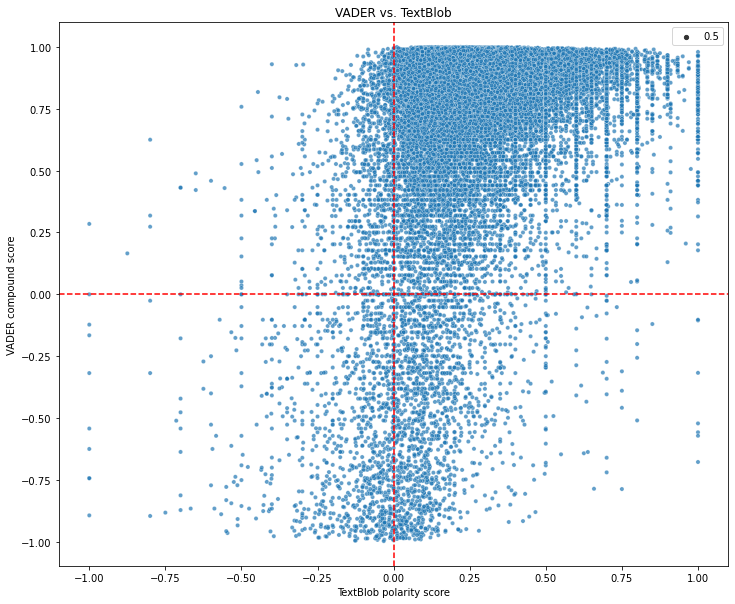

In [21]:
plt.figure(figsize = (12,10))
plt.axhline(y=0, color = 'r', linestyle = '--')
plt.axvline(x=0, color = 'r', linestyle = '--')
ax = sns.scatterplot(x="tb_polarity", y="v_compound", data=df_en, alpha = 0.7, size = 0.5)
ax.set_title("VADER vs. TextBlob")
ax.set_ylabel("VADER compound score")
ax.set_xlabel("TextBlob polarity score");

The above graph is a scatter plot of the Pearson correlation coefficient between the mentioned two algorithms VADER and TextBlob. In the above graph, the output brought to the conclusion that TextBlob was struggling with negative sentences.

We can see that the sentences considered Negative by VADER were mostly identified as positive by TextBlob. In the case of the 2nd, & 3rd quadrant both the algorithms have reached an agreement. But in the case of the 1st & 4th quadrant, there is a mismatch especially for the 4th quadrant, which has more contradictory data. It belongs to Positive as per TextBlob and Negative as per VADER.

Since VADER does better sentiment analysis when it comes to negative polarity detection, we will hence be using the VADER compound score instead.

## Export

In [22]:
df_en.head(1)

,Place,location,date,status,job_title,combined_text,language,tb_subjectivity,tb_polarity,tb_sentiment,v_compound,v_sentiment
0,startup_1,NaN,"Dec 11, 2018",Current Employee,Anonymous Employee,Best Company to work for People are smart and friendly Bureaucracy is slowing things down,en,0.432937,0.358433,1,0.8779,1


In [25]:
df_modeling = df_en.loc[:,('combined_text','v_sentiment')]

In [26]:
df_modeling.to_csv(f"../data/train_modeling.csv", index = False)